In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
counts = pd.read_csv(
    'data/FremontBridge.csv',
    index_col='Date',
    parse_dates=True,
    )
counts.head()

weather = pd.read_csv(
    'data/BicycleWeather.csv', 
    index_col='DATE', 
    parse_dates=True
    )
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,AWND_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,PGTM,...,WT14,WT14_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT22,WT22_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,4.7,",,W",NaN,NaN,NaN,...,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,4.5,",,W",NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,2.3,",,W",NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,4.7,",,W",NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.44467,-122.31442,112.5,6.1,",,W",NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
counts.columns = ['South', 'West', 'East']
counts['Total'] = counts.eval('West + East')
counts = counts[['West', 'East', 'Total']]
daily = counts.resample('d').sum()
daily = daily[['Total']] # remove other columns

In [28]:
daily.dropna().describe()

,Total
count,4168.000000
mean,2529.922985
std,1282.875365
min,11.000000
25%,1564.500000
50%,2410.000000
75%,3355.250000
max,6428.000000


In [29]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [30]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2024')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

C:\Users\Louie\AppData\Local\Temp\ipykernel_5308\1526959676.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

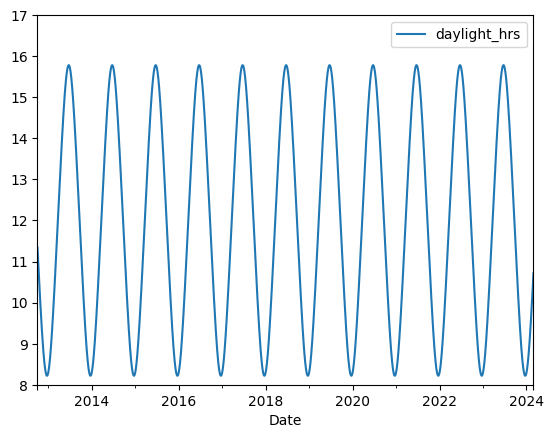

In [34]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)



In [37]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [38]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [39]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-02,1938.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681,0.0,1.390,1,0.000000
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,1.335,1,0.002740
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,1.360,1,0.005479
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,1.530,1,0.008219
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,1.585,1,0.010959


In [40]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

(19358.0, 19723.0)

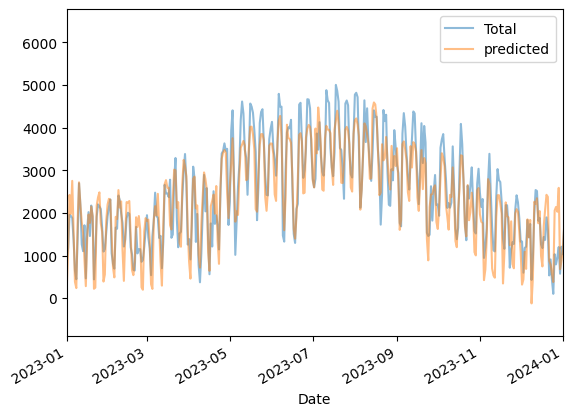

In [46]:
daily[['Total', 'predicted']].plot(alpha=0.5)
# # plt.xlim('2023', '2024')